In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
import copy

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = 'models/n_m_500.pth'

To do:

try small mu

for loop (convolve one basis at a time)

stop at every location (bandwidths, bubbles, smoothed basis, etc.) check after one iteration if the memory usage increase

In [3]:
device = torch.device("cuda")

In [4]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [5]:
# dt = 0.004
# num_steps = 501
dt = 0.002
num_steps = 1001
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([1001, 14641])

In [6]:
u_dot = lib.utils.u_dot(datas, dt)

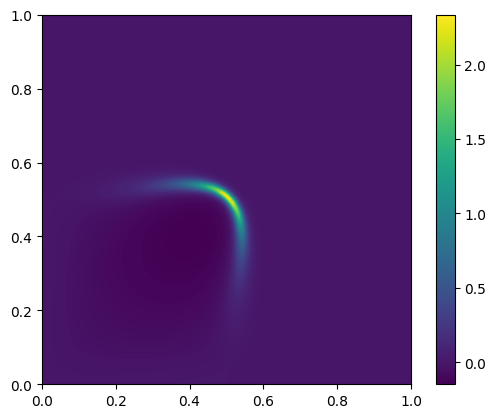

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[455].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [8]:
datas = torch.hstack((datas[:-1], u_dot))
datas.shape

torch.Size([1000, 29282])

In [9]:
m = 1000
clustering = KMeans(n_clusters=m, random_state=0, n_init="auto").fit(coords)

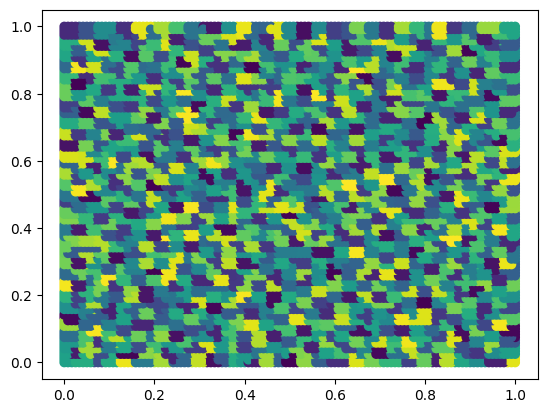

In [10]:
plt.scatter(coords_x, coords_y,c=clustering.labels_)

w: n x N

In [11]:
# # distance: N x mu
# # w: n x N ([0 element_size])
# # mu: number of neighbour elements
# def bubble(distance, w, mu):
#     n = w.shape[0]
#     window = torch.relu(-(distance.unsqueeze(0).expand(n, -1, -1)**2)/(w.unsqueeze(-1)*mu)**2 + 1)
#     window = window / torch.sum(window, dim=1, keepdim=True)
#     # n x N x mu
#     return window

In [12]:
# # x: n x N
# # neighbour_id: N x mu
# # w: n x N
# def convolve(x, neighbour_id, neighbour_distance, w, mu):
#     # n x N x mu
#     bubbles = bubble(neighbour_distance, w, mu)
#     return torch.sum(x[:, neighbour_id] * bubbles, dim=-1)

w: b x n x N

In [13]:
# # distance: N x mu
# # w: b x n x N ([0 element_size])
# # mu: number of neighbour elements
# def bubble(distance, w, mu):
#     n = w.shape[1]
#     b = w.shape[0]
#     window = torch.relu(-(distance.unsqueeze(0).unsqueeze(0).expand(b, n, -1, -1)**2)/(w.unsqueeze(-1)*mu)**2 + 1)
#     window = window / torch.sum(window, dim=1, keepdim=True)
#     # b x n x N x mu
#     return window

In [14]:
# # x(decoder): n x N
# # neighbour_id: N x mu
# # w: b x n x N
# def convolve(x, neighbour_id, neighbour_distance, w, mu):
#     b = w.shape[0]
#     # b x n x N x mu
#     bubbles = bubble(neighbour_distance, w, mu)
#     return torch.sum(x[:, neighbour_id].unsqueeze(0).expand(b,-1,-1,-1) * bubbles, dim=-1)


In [15]:
N = datas.shape[1] // 2
n = 20
# fixed support (length)
mu = int(np.ceil(N/100))
neighbour_distance, neighbour_id = lib.utils.topk_neighbours(coords, mu)

In [16]:
batch_size = 8
datas = datas.to(device)
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [17]:
ed = lib.nrbs_n_m.EncoderDecoder(N=N, n=n, mu=mu, m=m, neighbour_id=neighbour_id, neighbour_distance=neighbour_distance, clustering_labels=torch.tensor(clustering.labels_).type(torch.LongTensor), device=device)

In [18]:
# ed.nrbs = torch.load(model_name)

In [19]:
ed.train(train_data_loader=train_data, epochs=1000)

100%|██████████| 125/125 [00:15<00:00,  7.96it/s]


Loss = 124.7586403467172


100%|██████████| 125/125 [00:15<00:00,  7.92it/s]


Itr 0, curr_loss = 87.25191616616394, best_loss = 87.25191616616394, lr = 0.001


100%|██████████| 125/125 [00:15<00:00,  7.84it/s]


Itr 1, curr_loss = 73.29379868567916, best_loss = 73.29379868567916, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 2, curr_loss = 64.91981212295485, best_loss = 64.91981212295485, lr = 0.001


100%|██████████| 125/125 [00:18<00:00,  6.88it/s]


Itr 3, curr_loss = 56.91955932402799, best_loss = 56.91955932402799, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.11it/s]


Itr 4, curr_loss = 53.0939321079439, best_loss = 53.0939321079439, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.13it/s]


Itr 5, curr_loss = 49.596735787479595, best_loss = 49.596735787479595, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.30it/s]


Itr 6, curr_loss = 44.83256881465149, best_loss = 44.83256881465149, lr = 0.001


100%|██████████| 125/125 [00:18<00:00,  6.87it/s]


Itr 7, curr_loss = 39.6940299235514, best_loss = 39.6940299235514, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.16it/s]


Itr 8, curr_loss = 35.118915870509944, best_loss = 35.118915870509944, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.13it/s]


Itr 9, curr_loss = 30.668268104423348, best_loss = 30.668268104423348, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.22it/s]


Itr 10, curr_loss = 26.444712718611463, best_loss = 26.444712718611463, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.34it/s]


Itr 11, curr_loss = 22.504193635577092, best_loss = 22.504193635577092, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


Itr 12, curr_loss = 19.226415391181973, best_loss = 19.226415391181973, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.40it/s]


Itr 13, curr_loss = 15.996515318221272, best_loss = 15.996515318221272, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.33it/s]


Itr 14, curr_loss = 13.25996993569752, best_loss = 13.25996993569752, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.44it/s]


Itr 15, curr_loss = 11.35288073789211, best_loss = 11.35288073789211, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.08it/s]


Itr 16, curr_loss = 9.973987516892146, best_loss = 9.973987516892146, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.42it/s]


Itr 17, curr_loss = 8.822259029526768, best_loss = 8.822259029526768, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.38it/s]


Itr 18, curr_loss = 7.935421201594509, best_loss = 7.935421201594509, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 19, curr_loss = 7.319518216977092, best_loss = 7.319518216977092, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


Itr 20, curr_loss = 7.251819157689038, best_loss = 7.251819157689038, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.48it/s]


Itr 21, curr_loss = 6.242345320215204, best_loss = 6.242345320215204, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.45it/s]


Itr 22, curr_loss = 5.6748745493958035, best_loss = 5.6748745493958035, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.24it/s]


Itr 23, curr_loss = 5.317013435100199, best_loss = 5.317013435100199, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.24it/s]


Itr 24, curr_loss = 5.117973001958221, best_loss = 5.117973001958221, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.27it/s]


Itr 25, curr_loss = 4.941409030348158, best_loss = 4.941409030348158, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.20it/s]


Itr 26, curr_loss = 4.719024296381621, best_loss = 4.719024296381621, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.29it/s]


Itr 27, curr_loss = 4.541315582306454, best_loss = 4.541315582306454, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.21it/s]


Itr 28, curr_loss = 4.341639181873249, best_loss = 4.341639181873249, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.30it/s]


Itr 29, curr_loss = 4.076736289852262, best_loss = 4.076736289852262, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.46it/s]


Itr 30, curr_loss = 3.9954286827757075, best_loss = 3.9954286827757075, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.36it/s]


Itr 31, curr_loss = 4.082398894648536, best_loss = 3.9954286827757075, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.34it/s]


Itr 32, curr_loss = 4.551064771018804, best_loss = 3.9954286827757075, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.37it/s]


Itr 33, curr_loss = 3.990444346888324, best_loss = 3.990444346888324, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.36it/s]


Itr 34, curr_loss = 3.639659968189939, best_loss = 3.639659968189939, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.34it/s]


Itr 35, curr_loss = 3.563329994093909, best_loss = 3.563329994093909, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.37it/s]


Itr 36, curr_loss = 3.303957259731985, best_loss = 3.303957259731985, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.39it/s]


Itr 37, curr_loss = 3.226833398227685, best_loss = 3.226833398227685, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.20it/s]


Itr 38, curr_loss = 3.1648866148193244, best_loss = 3.1648866148193244, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


Itr 39, curr_loss = 3.1857637124949334, best_loss = 3.1648866148193244, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.39it/s]


Itr 40, curr_loss = 3.134894209713591, best_loss = 3.134894209713591, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 41, curr_loss = 3.2622367636593395, best_loss = 3.134894209713591, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.46it/s]


Itr 42, curr_loss = 3.2394934928373114, best_loss = 3.134894209713591, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.20it/s]


Itr 43, curr_loss = 3.0194139349105042, best_loss = 3.0194139349105042, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


Itr 44, curr_loss = 3.107761327921461, best_loss = 3.0194139349105042, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 45, curr_loss = 2.8255752671695094, best_loss = 2.8255752671695094, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.48it/s]


Itr 46, curr_loss = 2.819375262856432, best_loss = 2.819375262856432, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


Itr 47, curr_loss = 2.7780230035249622, best_loss = 2.7780230035249622, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.49it/s]


Itr 48, curr_loss = 2.8073219304366166, best_loss = 2.7780230035249622, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.41it/s]


Itr 49, curr_loss = 3.0045518698444282, best_loss = 2.7780230035249622, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.49it/s]


Itr 50, curr_loss = 2.9440618801587637, best_loss = 2.7780230035249622, lr = 0.001


100%|██████████| 125/125 [00:18<00:00,  6.89it/s]


Itr 51, curr_loss = 2.763445488454301, best_loss = 2.763445488454301, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.47it/s]


Itr 52, curr_loss = 2.7470176415485605, best_loss = 2.7470176415485605, lr = 0.001


100%|██████████| 125/125 [00:18<00:00,  6.79it/s]


Itr 53, curr_loss = 2.67511631853572, best_loss = 2.67511631853572, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.29it/s]


Itr 54, curr_loss = 2.6121379420191193, best_loss = 2.6121379420191193, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.43it/s]


Itr 55, curr_loss = 2.4371544644919236, best_loss = 2.4371544644919236, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 56, curr_loss = 2.4458806999744973, best_loss = 2.4371544644919236, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.44it/s]


Itr 57, curr_loss = 2.439077077424366, best_loss = 2.4371544644919236, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.40it/s]


Itr 58, curr_loss = 2.405003388866379, best_loss = 2.405003388866379, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 59, curr_loss = 2.534370013740013, best_loss = 2.405003388866379, lr = 0.001


100%|██████████| 125/125 [00:18<00:00,  6.80it/s]


Itr 60, curr_loss = 2.5274058159670894, best_loss = 2.405003388866379, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 61, curr_loss = 2.447601622725805, best_loss = 2.405003388866379, lr = 0.001


100%|██████████| 125/125 [00:18<00:00,  6.79it/s]


Itr 62, curr_loss = 2.3550142608088853, best_loss = 2.3550142608088853, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.18it/s]


Itr 63, curr_loss = 2.348101727848498, best_loss = 2.348101727848498, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.25it/s]


Itr 64, curr_loss = 2.494062564248421, best_loss = 2.348101727848498, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.34it/s]


Itr 65, curr_loss = 2.4602270938818247, best_loss = 2.348101727848498, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 66, curr_loss = 2.283365445863044, best_loss = 2.283365445863044, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.40it/s]


Itr 67, curr_loss = 2.183544707792098, best_loss = 2.183544707792098, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.49it/s]


Itr 68, curr_loss = 2.1165835308772136, best_loss = 2.1165835308772136, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 69, curr_loss = 2.0709161866719534, best_loss = 2.0709161866719534, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.49it/s]


Itr 70, curr_loss = 2.0514879979524423, best_loss = 2.0514879979524423, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.30it/s]


Itr 71, curr_loss = 2.048920207235988, best_loss = 2.048920207235988, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.31it/s]


Itr 72, curr_loss = 2.0433692266507415, best_loss = 2.0433692266507415, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.46it/s]


Itr 73, curr_loss = 2.0889235467066247, best_loss = 2.0433692266507415, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.24it/s]


Itr 74, curr_loss = 2.2472951966149295, best_loss = 2.0433692266507415, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.16it/s]


Itr 75, curr_loss = 2.1009516211623382, best_loss = 2.0433692266507415, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.43it/s]


Itr 76, curr_loss = 2.111592090799468, best_loss = 2.0433692266507415, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


Itr 77, curr_loss = 2.0138382472245513, best_loss = 2.0138382472245513, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.36it/s]


Itr 78, curr_loss = 2.0194759307904415, best_loss = 2.0138382472245513, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.36it/s]


Itr 79, curr_loss = 2.219366775799353, best_loss = 2.0138382472245513, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.30it/s]


Itr 80, curr_loss = 2.0796955399620964, best_loss = 2.0138382472245513, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.39it/s]


Itr 81, curr_loss = 2.07092771100671, best_loss = 2.0138382472245513, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 82, curr_loss = 2.0143425231404626, best_loss = 2.0138382472245513, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 83, curr_loss = 2.202562241813185, best_loss = 2.0138382472245513, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 84, curr_loss = 1.905436977685105, best_loss = 1.905436977685105, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.40it/s]


Itr 85, curr_loss = 1.882930402933059, best_loss = 1.882930402933059, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.34it/s]


Itr 86, curr_loss = 1.8928151060748115, best_loss = 1.882930402933059, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.17it/s]


Itr 87, curr_loss = 1.8414925330382241, best_loss = 1.8414925330382241, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 88, curr_loss = 1.768815721659949, best_loss = 1.768815721659949, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.47it/s]


Itr 89, curr_loss = 1.7404750243119242, best_loss = 1.7404750243119242, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.38it/s]


Itr 90, curr_loss = 1.7361051146132316, best_loss = 1.7361051146132316, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.37it/s]


Itr 91, curr_loss = 1.7497165720631511, best_loss = 1.7361051146132316, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.46it/s]


Itr 92, curr_loss = 1.7834813725720846, best_loss = 1.7361051146132316, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 93, curr_loss = 1.8898272681266368, best_loss = 1.7361051146132316, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.19it/s]


Itr 94, curr_loss = 2.346722369698321, best_loss = 1.7361051146132316, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.37it/s]


Itr 95, curr_loss = 2.184924792972392, best_loss = 1.7361051146132316, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 96, curr_loss = 2.027069963848079, best_loss = 1.7361051146132316, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.41it/s]


Itr 97, curr_loss = 1.7720488679385307, best_loss = 1.7361051146132316, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 98, curr_loss = 1.7046821761421354, best_loss = 1.7046821761421354, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.35it/s]


Itr 99, curr_loss = 1.6845798660542102, best_loss = 1.6845798660542102, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.33it/s]


Itr 100, curr_loss = 1.6660566160139376, best_loss = 1.6660566160139376, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.39it/s]


Itr 101, curr_loss = 1.636190762061379, best_loss = 1.636190762061379, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.38it/s]


Itr 102, curr_loss = 1.6253250903101217, best_loss = 1.6253250903101217, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.29it/s]


Itr 103, curr_loss = 1.8255027172103853, best_loss = 1.6253250903101217, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 104, curr_loss = 1.8185630183534296, best_loss = 1.6253250903101217, lr = 0.001


100%|██████████| 125/125 [00:17<00:00,  7.25it/s]


Itr 105, curr_loss = 1.6606218454753534, best_loss = 1.6253250903101217, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 106, curr_loss = 1.5720110312429567, best_loss = 1.5720110312429567, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 107, curr_loss = 1.5734161508034619, best_loss = 1.5720110312429567, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 108, curr_loss = 1.607640403240955, best_loss = 1.5720110312429567, lr = 0.001


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 109, curr_loss = 1.6171493723865364, best_loss = 1.5720110312429567, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.30it/s]


Itr 110, curr_loss = 1.8206374291855107, best_loss = 1.5720110312429567, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 111, curr_loss = 1.5339232044963018, best_loss = 1.5339232044963018, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.20it/s]


Itr 112, curr_loss = 1.464834828441906, best_loss = 1.464834828441906, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


Itr 113, curr_loss = 1.444691451863096, best_loss = 1.444691451863096, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 114, curr_loss = 1.4369095927209012, best_loss = 1.4369095927209012, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 115, curr_loss = 1.4347941908165496, best_loss = 1.4347941908165496, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 116, curr_loss = 1.4291828905036434, best_loss = 1.4291828905036434, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.46it/s]


Itr 117, curr_loss = 1.4260233140484988, best_loss = 1.4260233140484988, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.18it/s]


Itr 118, curr_loss = 1.421053103036235, best_loss = 1.421053103036235, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.39it/s]


Itr 119, curr_loss = 1.4179980648203243, best_loss = 1.4179980648203243, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 120, curr_loss = 1.4153506030820533, best_loss = 1.4153506030820533, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.04it/s]


Itr 121, curr_loss = 1.4090957551953078, best_loss = 1.4090957551953078, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.45it/s]


Itr 122, curr_loss = 1.4052360111185895, best_loss = 1.4052360111185895, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.34it/s]


Itr 123, curr_loss = 1.4019657103555418, best_loss = 1.4019657103555418, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 124, curr_loss = 1.397471219079433, best_loss = 1.397471219079433, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 125, curr_loss = 1.3903618591784916, best_loss = 1.3903618591784916, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.37it/s]


Itr 126, curr_loss = 1.383336438886301, best_loss = 1.383336438886301, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.28it/s]


Itr 127, curr_loss = 1.3832620905935513, best_loss = 1.3832620905935513, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.25it/s]


Itr 128, curr_loss = 1.3753042135054157, best_loss = 1.3753042135054157, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.41it/s]


Itr 129, curr_loss = 1.3740259581856935, best_loss = 1.3740259581856935, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.46it/s]


Itr 130, curr_loss = 1.36613778462289, best_loss = 1.36613778462289, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 131, curr_loss = 1.3608046742629465, best_loss = 1.3608046742629465, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.40it/s]


Itr 132, curr_loss = 1.3548235942887297, best_loss = 1.3548235942887297, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 133, curr_loss = 1.3500738576025373, best_loss = 1.3500738576025373, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.41it/s]


Itr 134, curr_loss = 1.3487932290666167, best_loss = 1.3487932290666167, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.48it/s]


Itr 135, curr_loss = 1.3409771334611649, best_loss = 1.3409771334611649, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 136, curr_loss = 1.3421891538826973, best_loss = 1.3409771334611649, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.34it/s]


Itr 137, curr_loss = 1.334547301167821, best_loss = 1.334547301167821, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.43it/s]


Itr 138, curr_loss = 1.3344737024982944, best_loss = 1.3344737024982944, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


Itr 139, curr_loss = 1.320132086862869, best_loss = 1.320132086862869, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.23it/s]


Itr 140, curr_loss = 1.3155363095684223, best_loss = 1.3155363095684223, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.45it/s]


Itr 141, curr_loss = 1.3127482727381015, best_loss = 1.3127482727381015, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 142, curr_loss = 1.315450718425875, best_loss = 1.3127482727381015, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.40it/s]


Itr 143, curr_loss = 1.3023456188623022, best_loss = 1.3023456188623022, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 144, curr_loss = 1.297879572113513, best_loss = 1.297879572113513, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


Itr 145, curr_loss = 1.2974520281992798, best_loss = 1.2974520281992798, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 146, curr_loss = 1.2989171489160751, best_loss = 1.2974520281992798, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.42it/s]


Itr 147, curr_loss = 1.293178302240655, best_loss = 1.293178302240655, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 148, curr_loss = 1.279678181922238, best_loss = 1.279678181922238, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.46it/s]


Itr 149, curr_loss = 1.2770781939199032, best_loss = 1.2770781939199032, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 150, curr_loss = 1.2711437256480074, best_loss = 1.2711437256480074, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.43it/s]


Itr 151, curr_loss = 1.2676776945724932, best_loss = 1.2676776945724932, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 152, curr_loss = 1.256260371290495, best_loss = 1.256260371290495, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.15it/s]


Itr 153, curr_loss = 1.254485398478677, best_loss = 1.254485398478677, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.13it/s]


Itr 154, curr_loss = 1.2503462839427129, best_loss = 1.2503462839427129, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.23it/s]


Itr 155, curr_loss = 1.245412149838551, best_loss = 1.245412149838551, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 156, curr_loss = 1.2415594113297073, best_loss = 1.2415594113297073, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.45it/s]


Itr 157, curr_loss = 1.237252651558645, best_loss = 1.237252651558645, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.47it/s]


Itr 158, curr_loss = 1.2431284331924501, best_loss = 1.237252651558645, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


Itr 159, curr_loss = 1.2408000893104743, best_loss = 1.237252651558645, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.11it/s]


Itr 160, curr_loss = 1.2373332159704977, best_loss = 1.237252651558645, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.16it/s]


Itr 161, curr_loss = 1.22740613701983, best_loss = 1.22740613701983, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


Itr 162, curr_loss = 1.2170299237239839, best_loss = 1.2170299237239839, lr = 0.0002


100%|██████████| 125/125 [00:18<00:00,  6.76it/s]


Itr 163, curr_loss = 1.2088085086543758, best_loss = 1.2088085086543758, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.27it/s]


Itr 164, curr_loss = 1.207059730379559, best_loss = 1.207059730379559, lr = 0.0002


100%|██████████| 125/125 [00:18<00:00,  6.79it/s]


Itr 165, curr_loss = 1.2022382189005247, best_loss = 1.2022382189005247, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


Itr 166, curr_loss = 1.198627953540228, best_loss = 1.198627953540228, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.29it/s]


Itr 167, curr_loss = 1.2020117928183325, best_loss = 1.198627953540228, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 168, curr_loss = 1.1968239832602667, best_loss = 1.1968239832602667, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.33it/s]


Itr 169, curr_loss = 1.184314404621142, best_loss = 1.184314404621142, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.49it/s]


Itr 170, curr_loss = 1.1834728221244515, best_loss = 1.1834728221244515, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.25it/s]


Itr 171, curr_loss = 1.1774628559714584, best_loss = 1.1774628559714584, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.41it/s]


Itr 172, curr_loss = 1.173468974488203, best_loss = 1.173468974488203, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 173, curr_loss = 1.1651081748344077, best_loss = 1.1651081748344077, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


Itr 174, curr_loss = 1.165114429428979, best_loss = 1.1651081748344077, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.22it/s]


Itr 175, curr_loss = 1.158148176786257, best_loss = 1.158148176786257, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


Itr 176, curr_loss = 1.15074078993807, best_loss = 1.15074078993807, lr = 0.0002


100%|██████████| 125/125 [00:18<00:00,  6.79it/s]


Itr 177, curr_loss = 1.1492317304756356, best_loss = 1.1492317304756356, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.49it/s]


Itr 178, curr_loss = 1.1604119923084195, best_loss = 1.1492317304756356, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.19it/s]


Itr 179, curr_loss = 1.1646006064995977, best_loss = 1.1492317304756356, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 180, curr_loss = 1.1560658729715596, best_loss = 1.1492317304756356, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 181, curr_loss = 1.1347624654768527, best_loss = 1.1347624654768527, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 182, curr_loss = 1.131618043768132, best_loss = 1.131618043768132, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


Itr 183, curr_loss = 1.1296367160941945, best_loss = 1.1296367160941945, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.30it/s]


Itr 184, curr_loss = 1.1204074077590358, best_loss = 1.1204074077590358, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.49it/s]


Itr 185, curr_loss = 1.1194730103014758, best_loss = 1.1194730103014758, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.37it/s]


Itr 186, curr_loss = 1.1132384348494815, best_loss = 1.1132384348494815, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.20it/s]


Itr 187, curr_loss = 1.1262687105867355, best_loss = 1.1132384348494815, lr = 0.0002


100%|██████████| 125/125 [00:18<00:00,  6.87it/s]


Itr 188, curr_loss = 1.1226098171256824, best_loss = 1.1132384348494815, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


Itr 189, curr_loss = 1.104882116562835, best_loss = 1.104882116562835, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.18it/s]


Itr 190, curr_loss = 1.1060412367882348, best_loss = 1.104882116562835, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.11it/s]


Itr 191, curr_loss = 1.1071193478501629, best_loss = 1.104882116562835, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 192, curr_loss = 1.1011595307386397, best_loss = 1.1011595307386397, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.15it/s]


Itr 193, curr_loss = 1.1092838955142366, best_loss = 1.1011595307386397, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.41it/s]


Itr 194, curr_loss = 1.1264025019661685, best_loss = 1.1011595307386397, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.42it/s]


Itr 195, curr_loss = 1.1354709899671311, best_loss = 1.1011595307386397, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 196, curr_loss = 1.0940981144151793, best_loss = 1.0940981144151793, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 197, curr_loss = 1.0933160136451663, best_loss = 1.0933160136451663, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.41it/s]


Itr 198, curr_loss = 1.0795188827687103, best_loss = 1.0795188827687103, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.39it/s]


Itr 199, curr_loss = 1.0717367166768317, best_loss = 1.0717367166768317, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.48it/s]


Itr 200, curr_loss = 1.0641014919248801, best_loss = 1.0641014919248801, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.48it/s]


Itr 201, curr_loss = 1.0796951836064155, best_loss = 1.0641014919248801, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 202, curr_loss = 1.0595778877358544, best_loss = 1.0595778877358544, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.49it/s]


Itr 203, curr_loss = 1.059508583855638, best_loss = 1.059508583855638, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 204, curr_loss = 1.052288823508567, best_loss = 1.052288823508567, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 205, curr_loss = 1.0477237476623578, best_loss = 1.0477237476623578, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 206, curr_loss = 1.0426920552088033, best_loss = 1.0426920552088033, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.02it/s]


Itr 207, curr_loss = 1.0424276766273837, best_loss = 1.0424276766273837, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.28it/s]


Itr 208, curr_loss = 1.0377209381257797, best_loss = 1.0377209381257797, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 209, curr_loss = 1.0325188710948139, best_loss = 1.0325188710948139, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.32it/s]


Itr 210, curr_loss = 1.0273452836095196, best_loss = 1.0273452836095196, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 211, curr_loss = 1.0275086104026883, best_loss = 1.0273452836095196, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 212, curr_loss = 1.02911603378061, best_loss = 1.0273452836095196, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 213, curr_loss = 1.0206002290022762, best_loss = 1.0206002290022762, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.47it/s]


Itr 214, curr_loss = 1.0148838462825676, best_loss = 1.0148838462825676, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.15it/s]


Itr 215, curr_loss = 1.0161125178491273, best_loss = 1.0148838462825676, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.21it/s]


Itr 216, curr_loss = 1.0144863525266588, best_loss = 1.0144863525266588, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.15it/s]


Itr 217, curr_loss = 1.0131666438093332, best_loss = 1.0131666438093332, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.00it/s]


Itr 218, curr_loss = 1.0235369519247375, best_loss = 1.0131666438093332, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.11it/s]


Itr 219, curr_loss = 1.020471856703682, best_loss = 1.0131666438093332, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.37it/s]


Itr 220, curr_loss = 1.0089025745366256, best_loss = 1.0089025745366256, lr = 0.0002


100%|██████████| 125/125 [00:18<00:00,  6.91it/s]


Itr 221, curr_loss = 0.9934327565359521, best_loss = 0.9934327565359521, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.39it/s]


Itr 222, curr_loss = 0.9973222241860623, best_loss = 0.9934327565359521, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.35it/s]


Itr 223, curr_loss = 0.9990707887812849, best_loss = 0.9934327565359521, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.42it/s]


Itr 224, curr_loss = 0.9998341427200751, best_loss = 0.9934327565359521, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.06it/s]


Itr 225, curr_loss = 0.9873758527387518, best_loss = 0.9873758527387518, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.48it/s]


Itr 226, curr_loss = 0.9866869568506171, best_loss = 0.9866869568506171, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.31it/s]


Itr 227, curr_loss = 1.0227540346438035, best_loss = 0.9866869568506171, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.07it/s]


Itr 228, curr_loss = 1.029689182339795, best_loss = 0.9866869568506171, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.42it/s]


Itr 229, curr_loss = 1.0255545510279789, best_loss = 0.9866869568506171, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.00it/s]


Itr 230, curr_loss = 0.9928984438011879, best_loss = 0.9866869568506171, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.43it/s]


Itr 231, curr_loss = 0.9798872411744155, best_loss = 0.9798872411744155, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 232, curr_loss = 0.9660364430599383, best_loss = 0.9660364430599383, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.43it/s]


Itr 233, curr_loss = 0.9587299590117929, best_loss = 0.9587299590117929, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.43it/s]


Itr 234, curr_loss = 0.9626813265606343, best_loss = 0.9587299590117929, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 235, curr_loss = 0.95925488857536, best_loss = 0.9587299590117929, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 236, curr_loss = 0.9525573807450084, best_loss = 0.9525573807450084, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.49it/s]


Itr 237, curr_loss = 0.9526063936266457, best_loss = 0.9525573807450084, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.40it/s]


Itr 238, curr_loss = 0.9515086583859194, best_loss = 0.9515086583859194, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.18it/s]


Itr 239, curr_loss = 0.9532590705801615, best_loss = 0.9515086583859194, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 240, curr_loss = 0.9472802084912382, best_loss = 0.9472802084912382, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 241, curr_loss = 0.9430645059815076, best_loss = 0.9430645059815076, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.47it/s]


Itr 242, curr_loss = 0.9451857964211625, best_loss = 0.9430645059815076, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 243, curr_loss = 0.9396990290574263, best_loss = 0.9396990290574263, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 244, curr_loss = 0.9311522450944197, best_loss = 0.9311522450944197, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.30it/s]


Itr 245, curr_loss = 0.9322020172881264, best_loss = 0.9311522450944197, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


Itr 246, curr_loss = 0.9233615543276777, best_loss = 0.9233615543276777, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 247, curr_loss = 0.923240611299025, best_loss = 0.923240611299025, lr = 0.0002


100%|██████████| 125/125 [00:16<00:00,  7.44it/s]


Itr 248, curr_loss = 0.9235835676012125, best_loss = 0.923240611299025, lr = 0.0002


100%|██████████| 125/125 [00:17<00:00,  7.11it/s]


Itr 249, curr_loss = 0.9270117644379636, best_loss = 0.923240611299025, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.36it/s]


Itr 250, curr_loss = 0.917905661112524, best_loss = 0.917905661112524, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.08it/s]


Itr 251, curr_loss = 0.901551612997817, best_loss = 0.901551612997817, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


Itr 252, curr_loss = 0.8970851563763623, best_loss = 0.8970851563763623, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 253, curr_loss = 0.8963444316679718, best_loss = 0.8963444316679718, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 254, curr_loss = 0.8955336301939779, best_loss = 0.8955336301939779, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.49it/s]


Itr 255, curr_loss = 0.8947504166026055, best_loss = 0.8947504166026055, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.47it/s]


Itr 256, curr_loss = 0.894430591054655, best_loss = 0.894430591054655, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.37it/s]


Itr 257, curr_loss = 0.8936416997406623, best_loss = 0.8936416997406623, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 258, curr_loss = 0.8941954972829396, best_loss = 0.8936416997406623, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.33it/s]


Itr 259, curr_loss = 0.8927977485143591, best_loss = 0.8927977485143591, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 260, curr_loss = 0.8916990752253695, best_loss = 0.8916990752253695, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.42it/s]


Itr 261, curr_loss = 0.8908177463117871, best_loss = 0.8908177463117871, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.39it/s]


Itr 262, curr_loss = 0.8898204720210714, best_loss = 0.8898204720210714, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 263, curr_loss = 0.8892755748801862, best_loss = 0.8892755748801862, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.36it/s]


Itr 264, curr_loss = 0.8881971853339393, best_loss = 0.8881971853339393, lr = 4e-05


100%|██████████| 125/125 [00:18<00:00,  6.79it/s]


Itr 265, curr_loss = 0.8869816889815322, best_loss = 0.8869816889815322, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.15it/s]


Itr 266, curr_loss = 0.8872192760814388, best_loss = 0.8869816889815322, lr = 4e-05


100%|██████████| 125/125 [00:18<00:00,  6.77it/s]


Itr 267, curr_loss = 0.8860013107333553, best_loss = 0.8860013107333553, lr = 4e-05


100%|██████████| 125/125 [00:18<00:00,  6.80it/s]


Itr 268, curr_loss = 0.8862337186928068, best_loss = 0.8860013107333553, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.29it/s]


Itr 269, curr_loss = 0.8845304564358921, best_loss = 0.8845304564358921, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.38it/s]


Itr 270, curr_loss = 0.8832466956803784, best_loss = 0.8832466956803784, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.20it/s]


Itr 271, curr_loss = 0.8817942341951149, best_loss = 0.8817942341951149, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.46it/s]


Itr 272, curr_loss = 0.8818270813330896, best_loss = 0.8817942341951149, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


Itr 273, curr_loss = 0.881035720987706, best_loss = 0.881035720987706, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 274, curr_loss = 0.8802369955244539, best_loss = 0.8802369955244539, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.26it/s]


Itr 275, curr_loss = 0.8787106368111338, best_loss = 0.8787106368111338, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


Itr 276, curr_loss = 0.8780298929631583, best_loss = 0.8780298929631583, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.19it/s]


Itr 277, curr_loss = 0.8780307361647713, best_loss = 0.8780298929631583, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 278, curr_loss = 0.8795353102793203, best_loss = 0.8780298929631583, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 279, curr_loss = 0.8779152597652077, best_loss = 0.8779152597652077, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 280, curr_loss = 0.8756009823676563, best_loss = 0.8756009823676563, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 281, curr_loss = 0.8740062332311761, best_loss = 0.8740062332311761, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 282, curr_loss = 0.874439589959775, best_loss = 0.8740062332311761, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 283, curr_loss = 0.8725568364985976, best_loss = 0.8725568364985976, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 284, curr_loss = 0.8719226323988223, best_loss = 0.8719226323988223, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  6.97it/s]


Itr 285, curr_loss = 0.8704753358621793, best_loss = 0.8704753358621793, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 286, curr_loss = 0.8704272649017475, best_loss = 0.8704272649017475, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.25it/s]


Itr 287, curr_loss = 0.8695847839492588, best_loss = 0.8695847839492588, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 288, curr_loss = 0.8681790393190859, best_loss = 0.8681790393190859, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.22it/s]


Itr 289, curr_loss = 0.8677025295854786, best_loss = 0.8677025295854786, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.29it/s]


Itr 290, curr_loss = 0.8660127527315615, best_loss = 0.8660127527315615, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 291, curr_loss = 0.8666040133232595, best_loss = 0.8660127527315615, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.56it/s]


Itr 292, curr_loss = 0.8653360919159272, best_loss = 0.8653360919159272, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 293, curr_loss = 0.8630697294624929, best_loss = 0.8630697294624929, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.45it/s]


Itr 294, curr_loss = 0.8628853050055274, best_loss = 0.8628853050055274, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 295, curr_loss = 0.8621358452323475, best_loss = 0.8621358452323475, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 296, curr_loss = 0.8616144793575072, best_loss = 0.8616144793575072, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 297, curr_loss = 0.8616200590647424, best_loss = 0.8616144793575072, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 298, curr_loss = 0.8601559218368958, best_loss = 0.8601559218368958, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 299, curr_loss = 0.8583013058556125, best_loss = 0.8583013058556125, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 300, curr_loss = 0.858122906345055, best_loss = 0.858122906345055, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


Itr 301, curr_loss = 0.8568515597875501, best_loss = 0.8568515597875501, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.57it/s]


Itr 302, curr_loss = 0.8570634683986296, best_loss = 0.8568515597875501, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.59it/s]


Itr 303, curr_loss = 0.8564789717790652, best_loss = 0.8564789717790652, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 304, curr_loss = 0.8548022463573404, best_loss = 0.8548022463573404, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.34it/s]


Itr 305, curr_loss = 0.8537534877554868, best_loss = 0.8537534877554868, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.09it/s]


Itr 306, curr_loss = 0.8520314603802114, best_loss = 0.8520314603802114, lr = 4e-05


100%|██████████| 125/125 [00:18<00:00,  6.94it/s]


Itr 307, curr_loss = 0.851104627861181, best_loss = 0.851104627861181, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.02it/s]


Itr 308, curr_loss = 0.851065620356559, best_loss = 0.851065620356559, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.38it/s]


Itr 309, curr_loss = 0.8502822747457723, best_loss = 0.8502822747457723, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.25it/s]


Itr 310, curr_loss = 0.8495456124250478, best_loss = 0.8495456124250478, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.43it/s]


Itr 311, curr_loss = 0.8482231094903361, best_loss = 0.8482231094903361, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.24it/s]


Itr 312, curr_loss = 0.847815633861295, best_loss = 0.847815633861295, lr = 4e-05


100%|██████████| 125/125 [00:18<00:00,  6.87it/s]


Itr 313, curr_loss = 0.8468324588253293, best_loss = 0.8468324588253293, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.29it/s]


Itr 314, curr_loss = 0.8456296643184971, best_loss = 0.8456296643184971, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.41it/s]


Itr 315, curr_loss = 0.844305162490208, best_loss = 0.844305162490208, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


Itr 316, curr_loss = 0.8444267516343201, best_loss = 0.844305162490208, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.41it/s]


Itr 317, curr_loss = 0.8429517049340701, best_loss = 0.8429517049340701, lr = 4e-05


100%|██████████| 125/125 [00:18<00:00,  6.74it/s]


Itr 318, curr_loss = 0.8421446529854494, best_loss = 0.8421446529854494, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.49it/s]


Itr 319, curr_loss = 0.8419560706840729, best_loss = 0.8419560706840729, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.52it/s]


Itr 320, curr_loss = 0.8409588068065459, best_loss = 0.8409588068065459, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


Itr 321, curr_loss = 0.84013868612497, best_loss = 0.84013868612497, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.50it/s]


Itr 322, curr_loss = 0.8386330706122688, best_loss = 0.8386330706122688, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.27it/s]


Itr 323, curr_loss = 0.8381501623918037, best_loss = 0.8381501623918037, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 324, curr_loss = 0.8369741430897131, best_loss = 0.8369741430897131, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.43it/s]


Itr 325, curr_loss = 0.8361357267624197, best_loss = 0.8361357267624197, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.20it/s]


Itr 326, curr_loss = 0.8359478543757028, best_loss = 0.8359478543757028, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.34it/s]


Itr 327, curr_loss = 0.8347122209411983, best_loss = 0.8347122209411983, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.16it/s]


Itr 328, curr_loss = 0.8332903852485979, best_loss = 0.8332903852485979, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.47it/s]


Itr 329, curr_loss = 0.8340404318524609, best_loss = 0.8332903852485979, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Itr 330, curr_loss = 0.8328390151417531, best_loss = 0.8328390151417531, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.43it/s]


Itr 331, curr_loss = 0.8309678697816567, best_loss = 0.8309678697816567, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.38it/s]


Itr 332, curr_loss = 0.8310711111709733, best_loss = 0.8309678697816567, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.36it/s]


Itr 333, curr_loss = 0.8301569470018647, best_loss = 0.8301569470018647, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.31it/s]


Itr 334, curr_loss = 0.828761054054104, best_loss = 0.828761054054104, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.55it/s]


Itr 335, curr_loss = 0.8286102671757583, best_loss = 0.8286102671757583, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 336, curr_loss = 0.8278521390201694, best_loss = 0.8278521390201694, lr = 4e-05


100%|██████████| 125/125 [00:17<00:00,  7.06it/s]


Itr 337, curr_loss = 0.8271790987560548, best_loss = 0.8271790987560548, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.53it/s]


Itr 338, curr_loss = 0.8263540733825328, best_loss = 0.8263540733825328, lr = 4e-05


100%|██████████| 125/125 [00:16<00:00,  7.51it/s]


Itr 339, curr_loss = 0.8252518371375541, best_loss = 0.8252518371375541, lr = 4e-05


100%|██████████| 125/125 [00:18<00:00,  6.85it/s]


Itr 340, curr_loss = 0.8239723844745083, best_loss = 0.8239723844745083, lr = 4e-05


 13%|█▎        | 16/125 [00:15<01:42,  1.06it/s]


KeyboardInterrupt: 

In [ ]:
ed.nrbs = torch.load(model_name)

In [20]:
approximates = ed(datas[999:1001, :N].to(device))
approximates.shape

torch.Size([1, 14641])

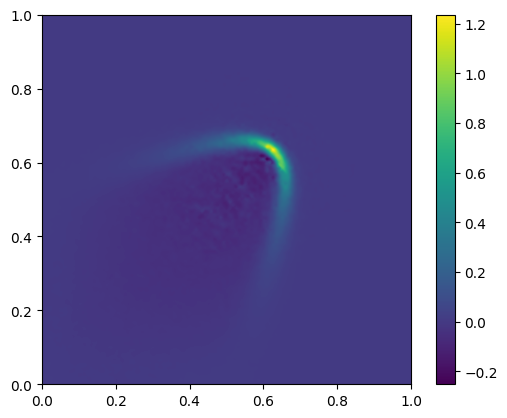

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

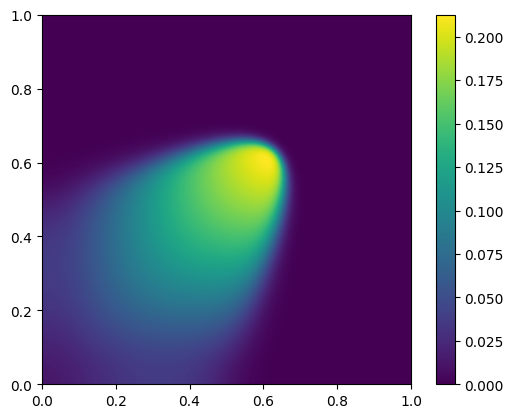

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999, :N].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

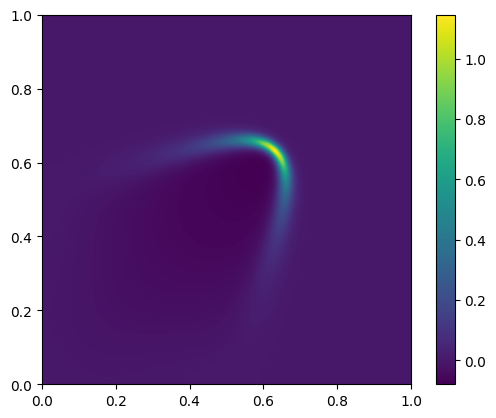

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[999, N:].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

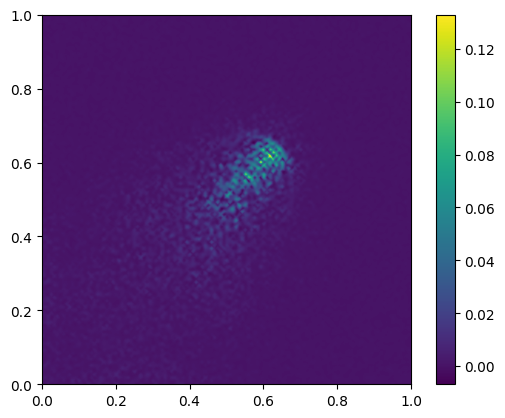

In [ ]:
abs_err = abs(datas[999, N:] - approximates[0]).detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),abs_err,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()


In [ ]:
encoded = ed.nrbs.encode(datas[999:1001, :N].to(device))
encoded.shape

torch.Size([1, 20])

In [ ]:
bandwidths = torch.sigmoid(ed.nrbs.bandwidth_layers(encoded[0]))
bandwidths = (1 / 60 - 10 / 60 / ed.nrbs.mu) * bandwidths + 10 / 60 / ed.nrbs.mu
bandwidths = bandwidths.reshape(n, m)
bandwidths = bandwidths[:, ed.nrbs.clustering_labels]

convolved_bases = ed.nrbs.convolve(
                ed.nrbs.decoder.weight,
                ed.nrbs.neighbour_id,
                ed.nrbs.neighbour_distance,
                bandwidths,
                ed.nrbs.mu,
            )

bandwidths = bandwidths.detach().cpu()
convolved_bases = convolved_bases.detach().cpu()

AttributeError: 'NRBS' object has no attribute 'bandwidth_layers'

In [ ]:
convolved_bases.shape

torch.Size([20, 14641])

In [ ]:
torch.min(bandwidths)

tensor(0.0011)

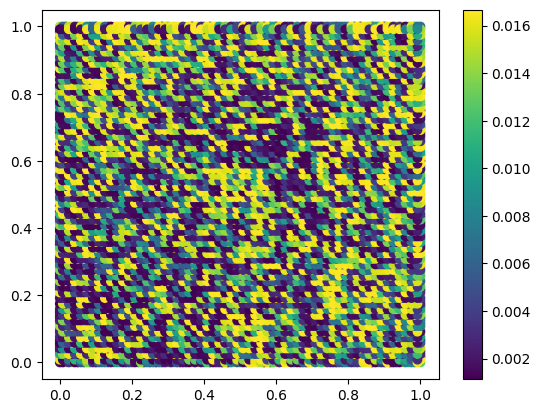

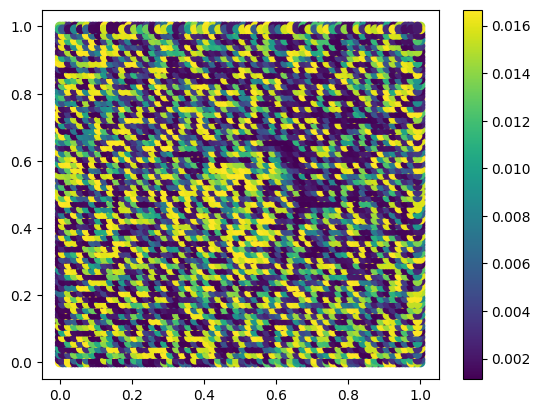

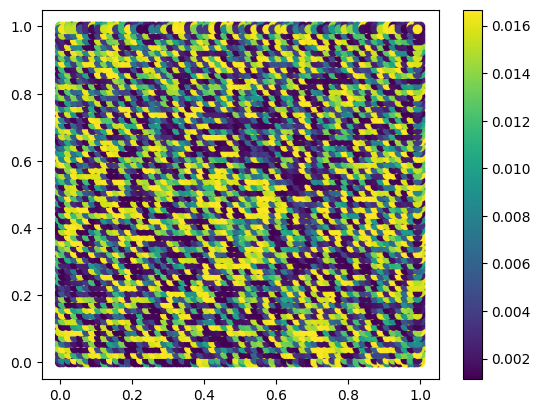

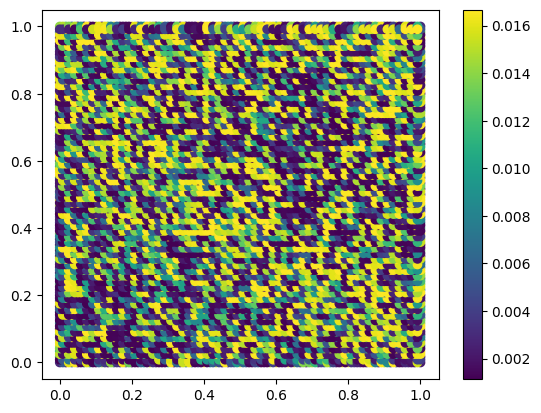

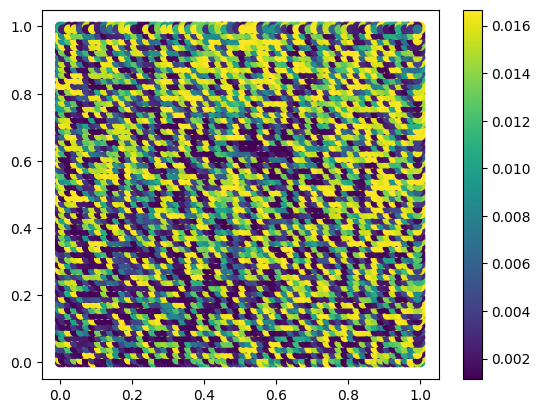

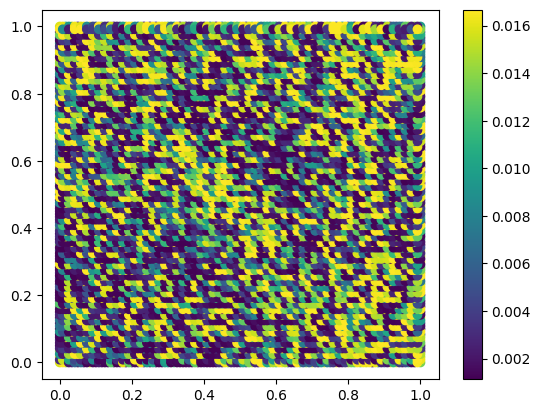

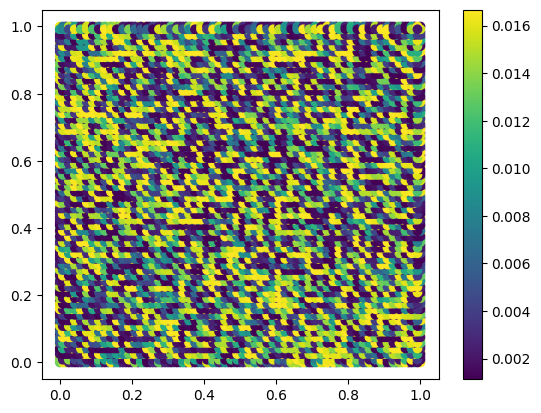

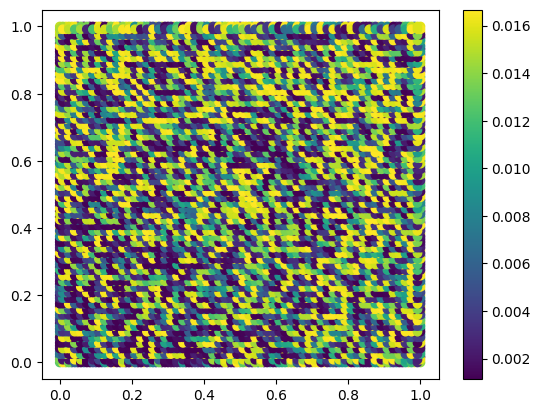

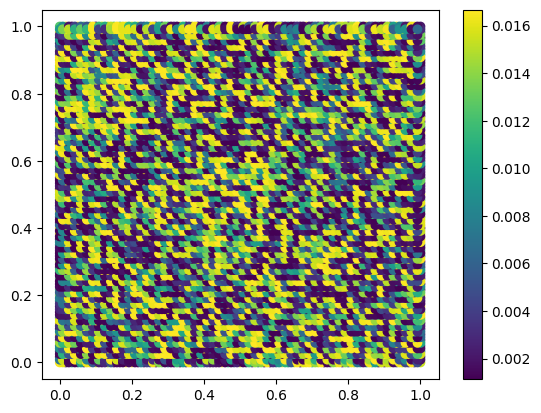

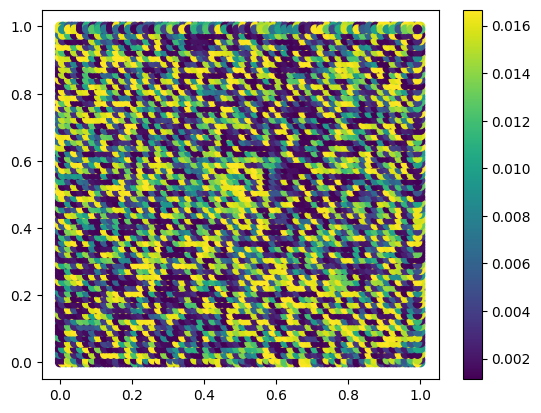

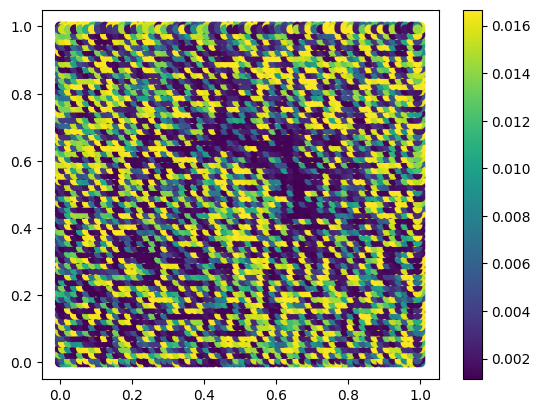

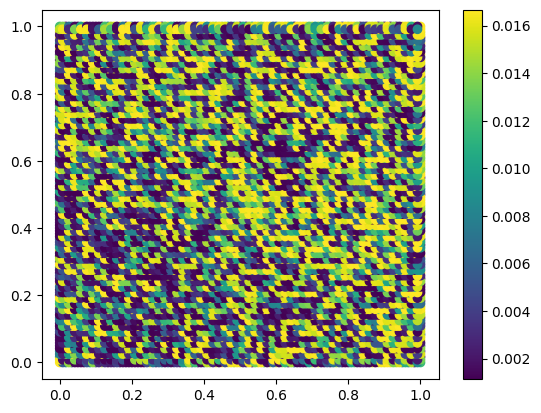

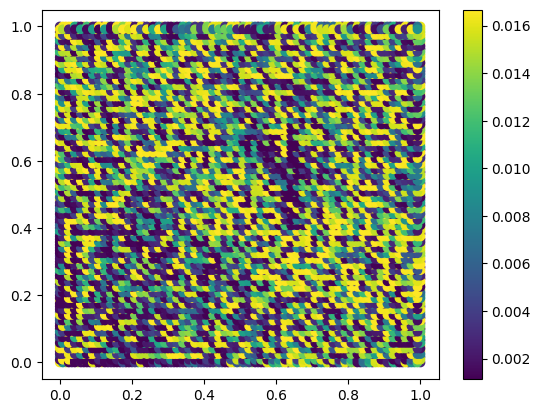

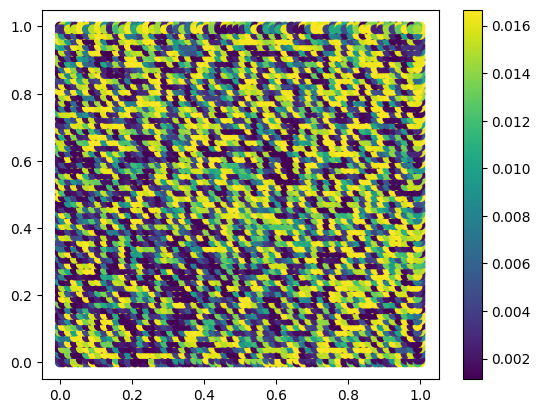

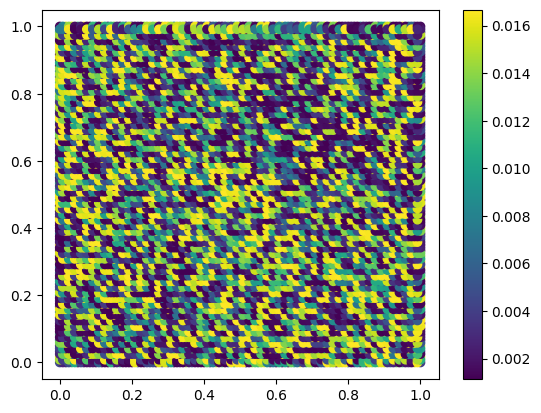

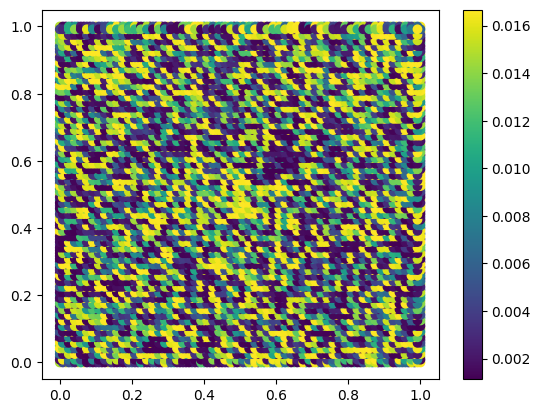

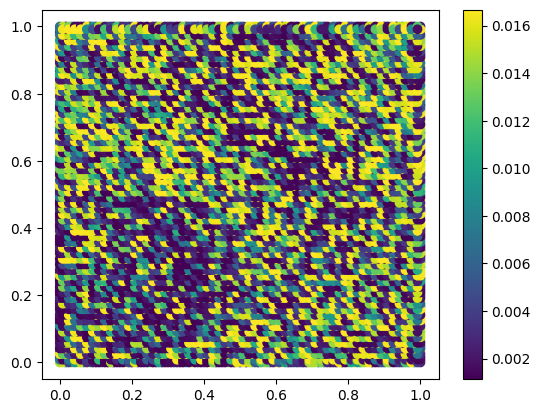

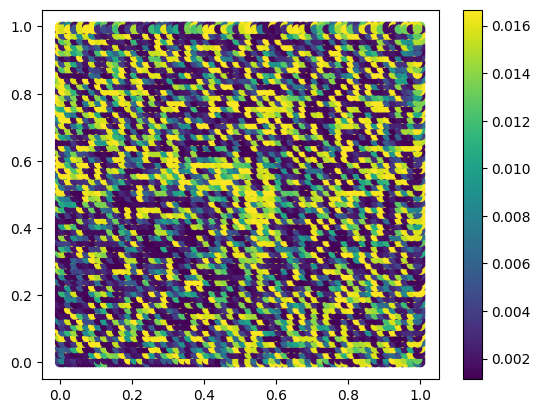

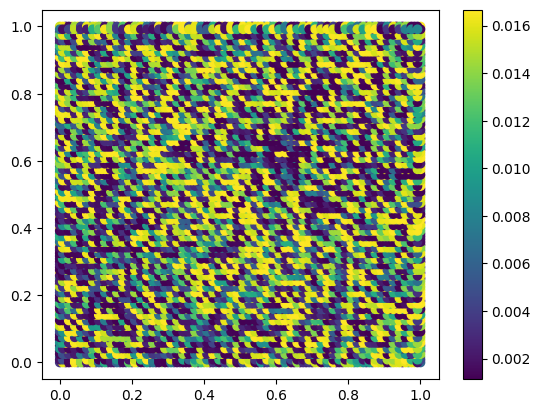

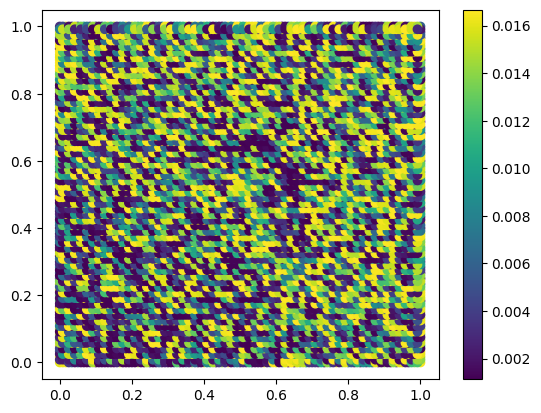

In [ ]:
for basis_id in range(n):
    plt.scatter(coords_x, coords_y,c=bandwidths[basis_id])
    plt.colorbar()
    plt.show()

In [ ]:
bs_n_m = torch.sigmoid(ed.nrbs.bandwidth_layers(encoded[0])) / 60
bs_n_m = bs_n_m.reshape(n, m)
bs_n_m = bs_n_m[:, ed.nrbs.clustering_labels]

In [ ]:
bubbles = ed.nrbs.bubble(neighbour_distance.to(device), bs_n_m, mu)

In [ ]:
bs_n_m

tensor([[0.0006, 0.0153, 0.0059,  ..., 0.0145, 0.0064, 0.0079],
        [0.0167, 0.0098, 0.0027,  ..., 0.0163, 0.0015, 0.0011],
        [0.0005, 0.0167, 0.0003,  ..., 0.0003, 0.0016, 0.0166],
        ...,
        [0.0025, 0.0097, 0.0166,  ..., 0.0007, 0.0161, 0.0140],
        [0.0025, 0.0003, 0.0127,  ..., 0.0003, 0.0002, 0.0077],
        [0.0160, 0.0164, 0.0040,  ..., 0.0010, 0.0144, 0.0020]],
       device='cuda:0', grad_fn=<IndexBackward0>)

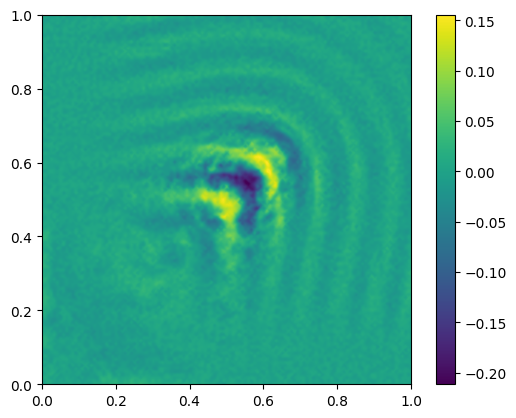

In [ ]:
z = ed.nrbs.decoder.weight[1].tolist()

vmin = min(z)
vmax = max(z)

 # target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1],vmin=vmin,vmax=vmax)
plt.colorbar()
plt.show()


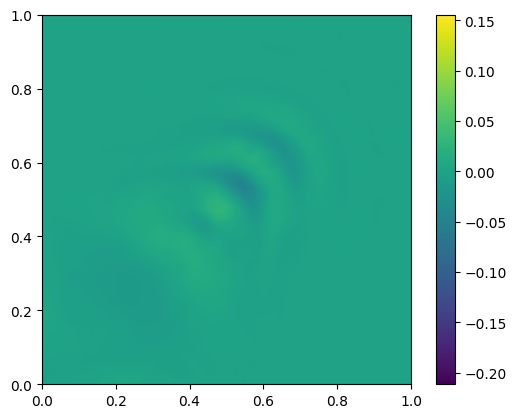

In [ ]:
z = convolved_bases[0].tolist()
# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1],vmin=vmin,vmax=vmax)
plt.colorbar()
plt.show()

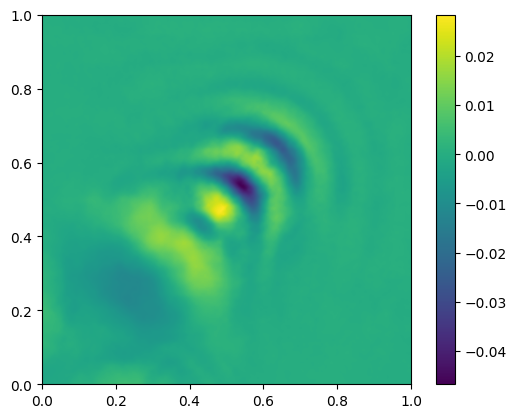

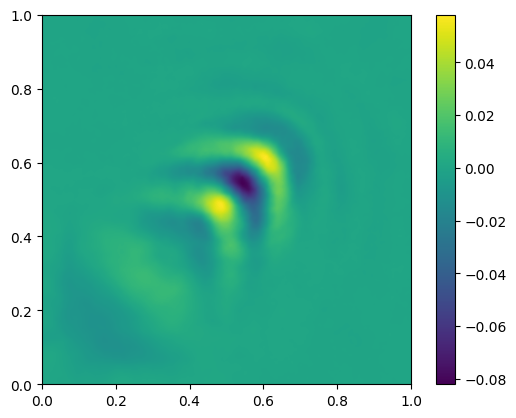

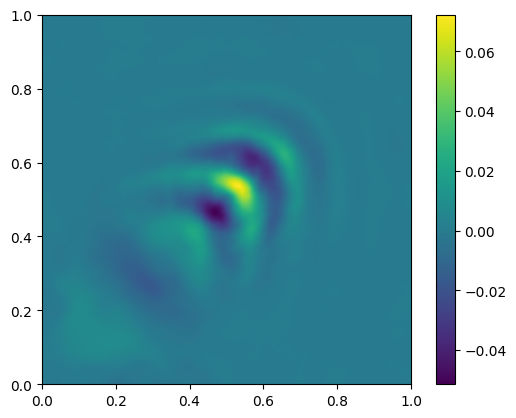

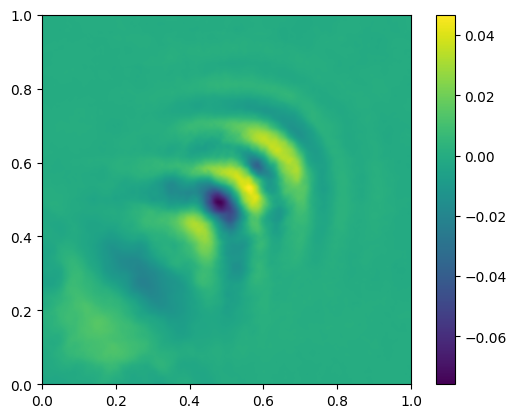

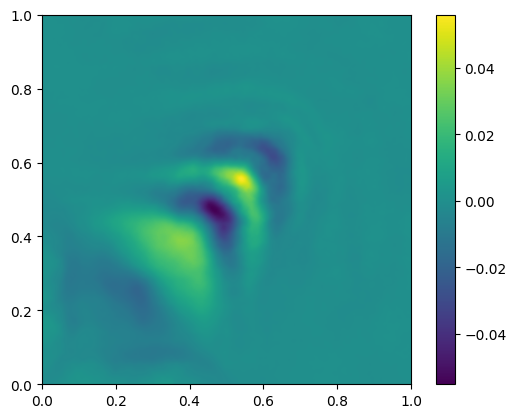

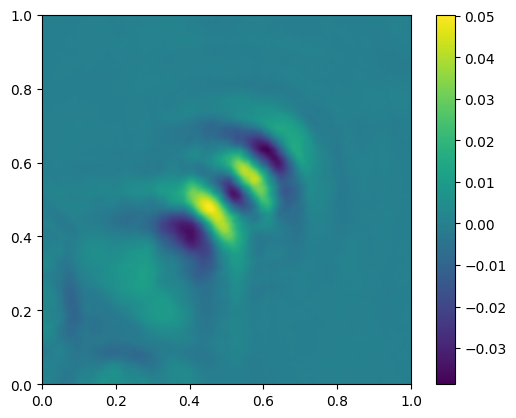

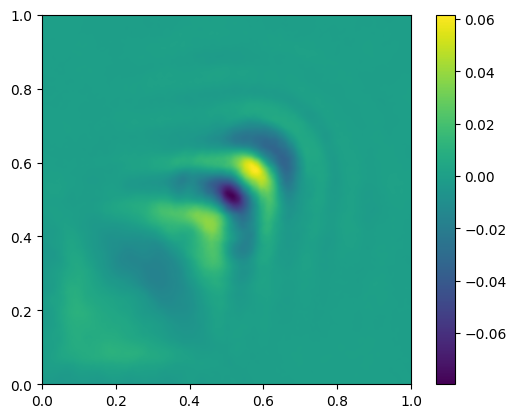

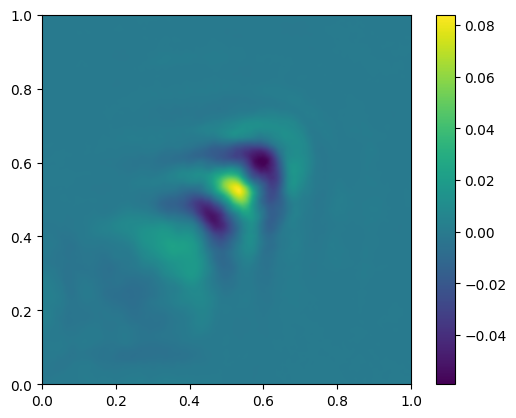

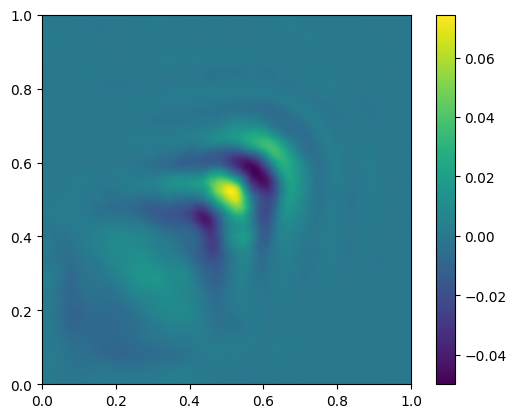

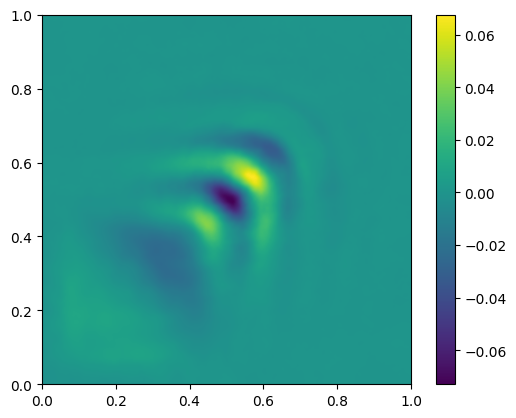

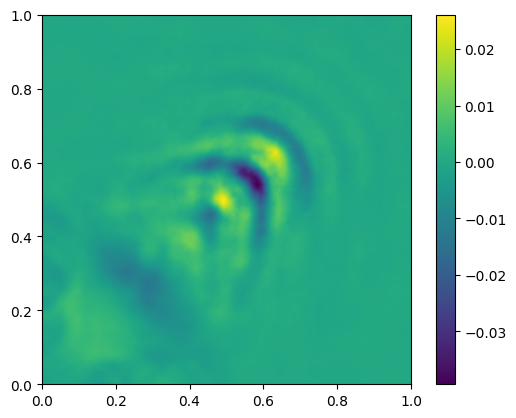

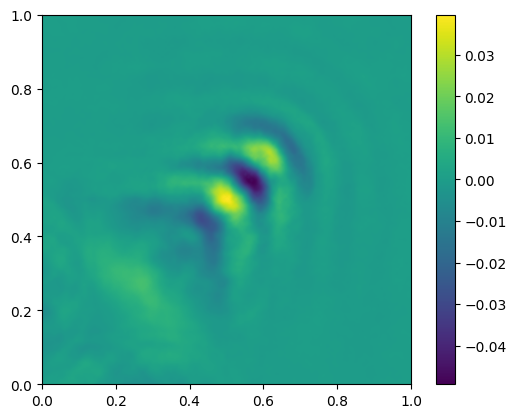

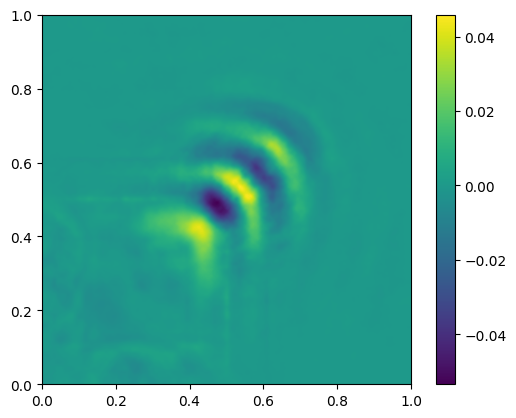

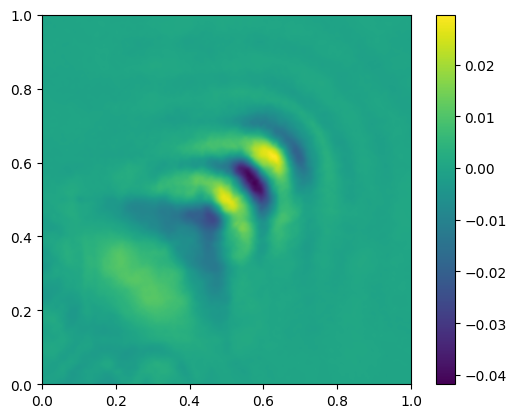

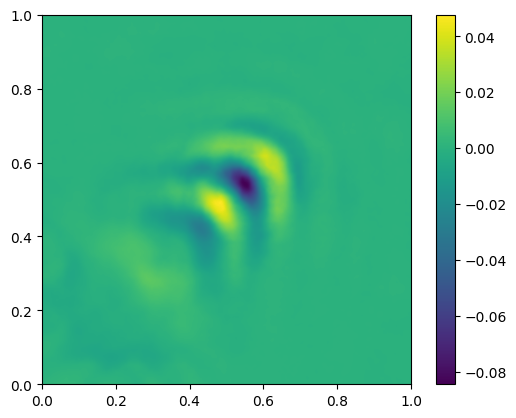

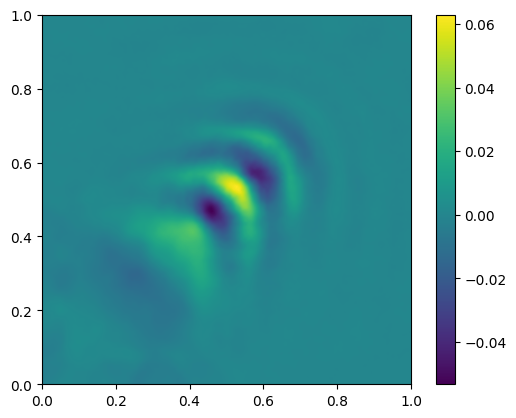

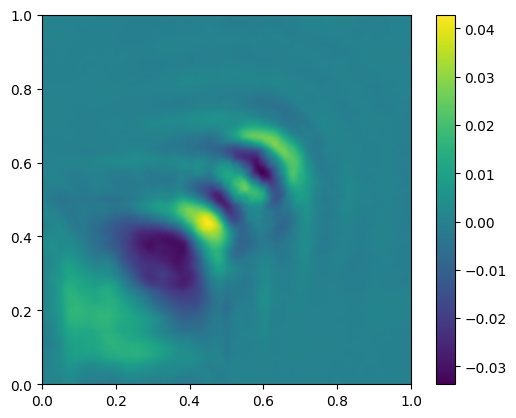

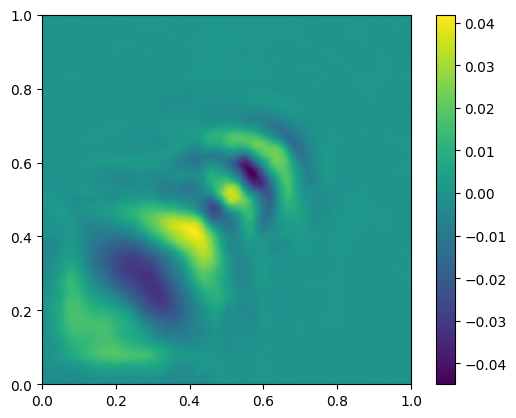

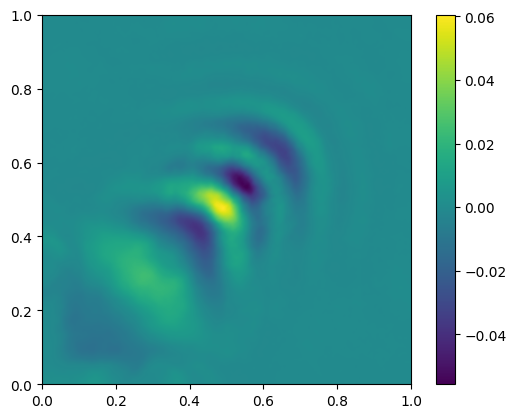

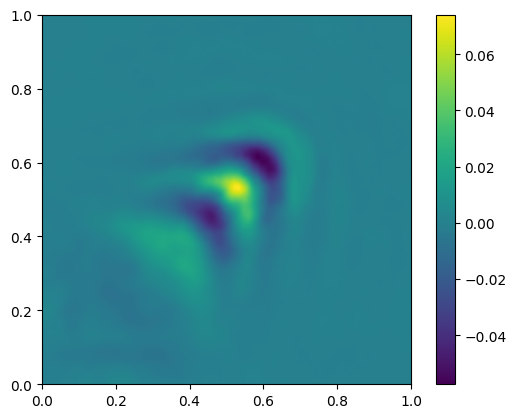

In [ ]:
for basis_id in range(n):
    z = convolved_bases[basis_id].tolist()

    # target grid to interpolate to
    xi = yi = np.linspace(0,1.0,1200)
    xi,yi = np.meshgrid(xi,yi)

    # set mask
    # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

    # interpolate
    zi = griddata((x,y),z,(xi,yi),method='cubic')

    plt.imshow(zi,origin='lower', extent=[0,1,0,1])
    plt.colorbar()
    plt.show()

In [ ]:
# bws = ed.nrbs.bandwidth_layer(ed.nrbs.encode(datas[499:501].to(device)))
# bws = torch.sigmoid(bws)

In [ ]:
# bws = ed.nrbs.get_bandwidth(ed.nrbs.encode(datas[499:501].to(device)))

In [ ]:
# # data coordinates and values
# z = bws[0].detach().cpu().tolist()

# # target grid to interpolate to
# xi = yi = np.linspace(0,1.0,1200)
# xi,yi = np.meshgrid(xi,yi)

# # set mask
# # mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# # interpolate
# zi = griddata((x,y),z,(xi,yi),method='cubic')

# plt.imshow(zi,origin='lower', extent=[0,1,0,1])
# plt.colorbar()